In [2]:
import os
os.chdir('../../src/models/')

from spread_model import *
from patient_evolution import *
from joblib import Parallel, delayed
import plotly.graph_objects as go
import pickle as pkl


# Source: https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-05-08-COVID19-Report-21.pdf

Start Day: Feb 24th
End Day: May 4th

Total Time: 70 days

Estimated attack rate: 3.5%

Start of intervention:

March 23th (day 28)

In [47]:
import pickle as pkl
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import os
os.chdir('../../src/models/')

def plot_average_curve(sims, title, feature, absolute=False, capacity=False):
    fig = go.Figure()
      
    for col in [feature]:
        tmp=[sims[i][col] for i in range(len(sims))]
        infected_sims = pd.DataFrame(tmp).T.fillna(0)
        infected_sims['mean'] = infected_sims.apply(np.mean, axis=1)
        infected_sims['sd'] = infected_sims.drop(columns='mean').apply(np.std, axis=1)
        infected_sims = infected_sims.drop(columns=col)
    
    x = infected_sims.index.to_list()
    y = infected_sims['mean']
    sd = infected_sims['sd']
    print(f'Mean at day 70 {y.iloc[-1]}')
    print(f'Sd at day 70 {sd.iloc[-1]}')
    
    if absolute: 
        y  =  y*12e6
        sd = sd*12e6

    fig.add_trace(go.Scatter(x=x, y=y,
        fill=None,
        mode='lines',
        line_color='indigo',
         name="Average Curve"
        ))

    fig.add_trace(go.Scatter(x=x, y=y+sd,
        fill=None,
        mode='lines',
        line_color='magenta',
        showlegend=False
       ))

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines', line_color='indigo',      name="Standard Deviation"))

    fig.add_trace(go.Scatter(x=x, y=y-sd,
        fill=None,
        mode='lines',
        line_color='magenta',    showlegend=False
        ))


    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines', line_color='indigo',     showlegend=False
    ))
    
    if capacity:
        fig.add_trace(go.Scatter(
            x=x,
            y=len(x)*[0.0025],
            mode='lines', line_color='yellow', name='Capacity',    showlegend=True
        ))

    fig.update_layout(title = title)

    fig.show()

In [17]:
def simulate_pandemic(restrictions={'work':0, 'school': 0, 'home':0, 'neighbor':0},
                                  initial_infection=.0001, 
                                  p_r={'neighbor':.1, 'work':.3, 'school':.5, 'home':.7},
                                  lambda_leak=0, pop_size = None,
                                  graph_model = 'SP', file_path = None, 
                                  seed = None, it=None, policy=False):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, file_path, 
                                                                    pop_size, seed)
    
    data_per_region = []
       
    zones = range(1, 343)
    
    policy_chosen = []
    
    infected_per_relation = {
        'home': 0,
        'work' : 0,
        'school': 0,
        'neighbor': 0
    }
    
    quarentine_restrictions = {
        'work':0.6, 'school': 1, 'home':0, 'neighbor':0.4
    }
    
    regular_restrictions = {
        'work':0, 'school': 0, 'home':0, 'neighbor':0
    }
    
    for day in tqdm(range(500)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
            
        update_graph(G)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected])
        
        
        if graph_model == 'SP':
            
            data_per_region.append(current_status_by_zone(G))
            
            #Lockdown
            if policy:
                if day >= 28:
                    restrictions = quarentine_restrictions

                #if day >= 97:
                #    restrictions = regular_restrictions
                policy_chosen.append(list(restrictions.values()))
                
            newly_infected = spread_one_step(G, p_r, restrictions, infected_per_relation, 
                                                lambda_leak, day)
        
            data[-1].append(newly_infected)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 
               'contacts_infected_mean', 'newly_infected']

    time_series = pd.DataFrame(data, columns=columns)
    
    #return time_series, G, data_per_region, infected_per_relation, policy_chosen
    return time_series

In [5]:
pr_home = .05
p_r = {
    'work':pr_home/3, 'school':(2*pr_home)/3, 'home':pr_home, 'neighbor':pr_home/7 }

In [6]:
end_policy_may_pr05 = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=True, file_path='SP_multiGraph.gpickle') for i in range(6))

In [12]:
plot_average_curve(end_policy_may_pr05, 'end_policy_may_pr05', 'infected', absolute=True, capacity=False)

In [13]:
no_policy = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=False, file_path='SP_multiGraph.gpickle') for i in range(6))

In [14]:
plot_average_curve(no_policy, 'no_policy', 'infected', absolute=True, capacity=False)

In [22]:
policy_all = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=True, file_path='SP_multiGraph.gpickle') for i in range(6))

In [25]:
plot_average_curve(policy_all, 'policy_all', 'susceptible', absolute=False, capacity=False)

In [26]:
# Check attack rate at day 70 -> Should be aroun 3,5% 

def simulate_pandemic(restrictions={'work':0, 'school': 0, 'home':0, 'neighbor':0},
                                  initial_infection=.0001, 
                                  p_r={'neighbor':.1, 'work':.3, 'school':.5, 'home':.7},
                                  lambda_leak=0, pop_size = None,
                                  graph_model = 'SP', file_path = None, 
                                  seed = None, it=None, policy=False):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, file_path, 
                                                                    pop_size, seed)
    
    data_per_region = []
       
    zones = range(1, 343)
    
    policy_chosen = []
    
    infected_per_relation = {
        'home': 0,
        'work' : 0,
        'school': 0,
        'neighbor': 0
    }
    
    quarentine_restrictions = {
        'work':0.6, 'school': 1, 'home':0, 'neighbor':0.4
    }
    
    regular_restrictions = {
        'work':0, 'school': 0, 'home':0, 'neighbor':0
    }
    
    for day in tqdm(range(70)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
            
        update_graph(G)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected])
        
        
        if graph_model == 'SP':
            
            data_per_region.append(current_status_by_zone(G))
            
            #Lockdown
            if policy:
                if day >= 28:
                    restrictions = quarentine_restrictions

                #if day >= 97:
                #    restrictions = regular_restrictions
                policy_chosen.append(list(restrictions.values()))
                
            newly_infected = spread_one_step(G, p_r, restrictions, infected_per_relation, 
                                                lambda_leak, day)
        
            data[-1].append(newly_infected)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 
               'contacts_infected_mean', 'newly_infected']

    time_series = pd.DataFrame(data, columns=columns)
    
    #return time_series, G, data_per_region, infected_per_relation, policy_chosen
    return time_series

In [27]:
pr_home = .05
p_r = {
    'work':pr_home/3, 'school':(2*pr_home)/3, 'home':pr_home, 'neighbor':pr_home/7 }

attack_rate_estimate_05 = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=True, file_path='SP_multiGraph.gpickle') for i in range(60))

In [62]:
pkl.dump(attack_rate_estimate_05, open('attack_rate_05.pkl', 'wb'))

In [31]:
plot_average_curve(attack_rate_estimate_05, 'attack_rate_estimate_05', 'susceptible', absolute=False, capacity=False)

In [30]:
pr_home = .035
p_r = {
    'work':pr_home/3, 'school':(2*pr_home)/3, 'home':pr_home, 'neighbor':pr_home/7 }

attack_rate_estimate_035 = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=True, file_path='SP_multiGraph.gpickle') for i in range(60))

In [61]:
pkl.dump(attack_rate_estimate_035, open('attack_rate_035.pkl', 'wb'))

In [32]:
plot_average_curve(attack_rate_estimate_035, 'attack_rate_estimate_035', 'susceptible', absolute=False, capacity=False)

In [33]:
pr_home = .04
p_r = {
    'work':pr_home/3, 'school':(2*pr_home)/3, 'home':pr_home, 'neighbor':pr_home/7 }

attack_rate_estimate_04 = Parallel(n_jobs=6)(delayed(simulate_pandemic)\
               (initial_infection = .0001, p_r = p_r, 
                policy=True, file_path='SP_multiGraph.gpickle') for i in range(60))

In [41]:
attack_rate_04 = [i for i in attack_rate_estimate_04 if len(i) == 71]


In [60]:
pkl.dump(attack_rate_04, open('attack_rate_04.pkl', 'wb'))

In [48]:
plot_average_curve(attack_rate_04, 'attack_rate_04', 'susceptible', absolute=False, capacity=False)

Mean at day 70 0.9696813832991044
Sd at day 70 0.02214754376295375


In [50]:
attack_rate = 1-0.9696813832991044
attack_rate

0.03031861670089564

In [51]:
sd = 0.02214754376295375

In [52]:
upper_ic = attack_rate + (1.96*(sd))/(np.sqrt(60))
upper_ic

0.03592271848691254

In [57]:
lower_ic = attack_rate - (1.96*(sd))/(np.sqrt(60))
lower_ic

0.024714514914878746

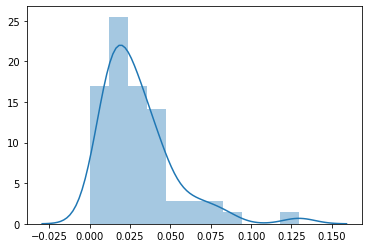

In [55]:
import seaborn as sns
sns.distplot([1 - i['susceptible'].iloc[-1] for i in attack_rate_estimate_04])

In [58]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h